In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
# input parameters
num_sections = 100
num_plots_per_section = 211
total_plots = num_sections * num_plots_per_section
mw_mean = 10
mw_stdev = 6.5
mw_present_proportion = .2
srs_n = 60
clusters_to_sample = 10
plots_sampled_per_cluster = 6
z = 1.64  # z score for confidence interval
reps = 1000  # bootstrap repitions

In [3]:
# create arrays for sections, plots, and milkweed
sections = np.repeat(np.arange(0,num_sections,1), num_plots_per_section)
plots = np.tile(np.arange(0,num_plots_per_section,1), num_sections)
mw_present = np.random.normal(mw_mean, mw_stdev, int(total_plots * mw_present_proportion)).clip(min=0).astype('int')
mw = np.append(mw_present, np.repeat([0], int((1 - mw_present_proportion) * total_plots)))
random.shuffle(mw)

len(sections) == len(plots) == len(mw)

True

In [4]:
# create dataframe
df = pd.DataFrame({'section': sections, 'plot': plots, 'mw': mw})
df.head()

,section,plot,mw
0,0,0,0
1,0,1,0
2,0,2,13
3,0,3,0
4,0,4,0


In [5]:
# check true values
df['mw'].sum()

40795

In [6]:
df['mw'].mean()

1.9334123222748816

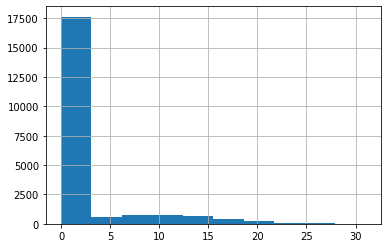

In [7]:
df['mw'].hist()

In [8]:
# take srs
srs_n = 60
srs = df.sample(srs_n)

In [9]:
srs['mw'].sum() * total_plots / srs_n

26375.0

In [10]:
srs['mw'].mean()

1.25

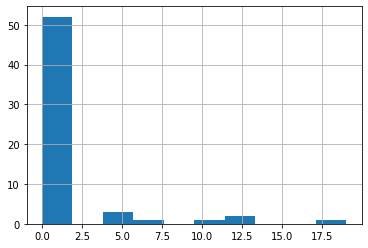

In [11]:
srs['mw'].hist()

In [12]:
def srs_error(N, df):
    """
    calculates standard error for a simple random sample
    df: DataFrame with simple random sample
    
    s2 = Sum(x - xbar)^2 / (n - 1)
    
    SE = sqrt((1 - n / N) * s2 / n)
    """
    
    n = len(df)
    
    dff = df.copy()
    xbar = dff['mw'].mean()
    
    dff['var'] = dff['mw'].apply(lambda x: (x - xbar)**2)
    
    s2 = np.sqrt(dff['var'].sum() / (len(dff) - 1))
    
    return np.sqrt((1 - n/N) * s2/n)

In [13]:
srs_error(total_plots, srs)

0.247631390062579

In [14]:
def take_cluster_sample(df):
    """draws a srs of clusters and srs of plots
    df: population dataframe
    """
    clusters = np.random.choice(df['section'].unique(), clusters_to_sample, replace=False)
    cluster_sample = []
    for cluster in clusters:
        filt = df['section'] == cluster
        sample = df.loc[filt].sample(plots_sampled_per_cluster)
        cluster_sample.append(sample)
    cluster_sample = pd.concat(cluster_sample)
    
    return cluster_sample

In [15]:
cluster_sample = take_cluster_sample(df)
len(cluster_sample)

60

In [16]:
cluster_sample['mw'].mean()

2.0

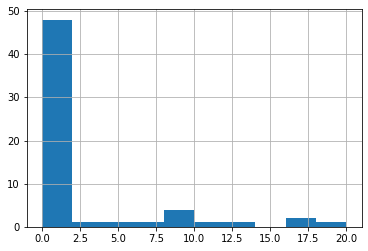

In [17]:
cluster_sample['mw'].hist()

In [18]:
def cluster_mean(N, M, Mh, df):
    """
    N: number of clusters in the population
    M: number of plots in the population
    Mh: number of plots per cluster
    df: DataFrame with cluster sample
    
    xbar = (N/ (n * M)) * Sum(Mh * xbarh)
    where n: number of clusters in sample
          Mh: number of plots in cluster h
          xbarh: mean from cluster h
    
    """
    
    sections = df['section'].unique()
    
    n = len(sections)
    
    dff = df.groupby('section').mean()
    dff['total'] = dff['mw'] * Mh
    total = dff['total'].sum()
    
    return (N / (n * M)) * total


In [19]:
cluster_mean(num_sections, total_plots, num_plots_per_section, cluster_sample)

2.0

In [20]:
def cluster_total(N, Mh, df):
    """
    total for a cluster sample
    df: DataFrame with cluster sample
    N: number of clusters in the population
    
    tbar = N / n * Sum(Mh * xbarh)
    where n: number of clusters in the sample
        xbarh: the mean for the cluster
        mh: the number of plots sampled in cluster h  
    """
    
    sections = df['section'].unique()
    
    n = len(sections)
    
    dff = df.groupby('section').mean()
    dff['total'] = dff['mw'] * Mh
    total = dff['total'].sum()
    
    return (N / n) * total
    

In [21]:
cluster_total(num_sections, num_plots_per_section, cluster_sample)

42200.0

In [22]:
def cluster_variance(section, df):
    """
    returns the within-cluster variance for the specified cluster
    section: cluster ID number
    df: DataFrame with cluster sample 
    
    s2h = Sum(xih - xbarh)^2 / (mh -1)
    where xih: the value of the ith element from cluster h
        xbarh: the mean for the cluster
        mh: the number of plots sampled in cluster h 
    """
    
    filt = df['section'] == section
    dff = df.loc[filt].copy()
    xbarh = dff['mw'].mean()
    mh = len(dff)
    dff['var'] = dff['mw'].apply(lambda x: (x - xbarh)**2)
    
    return dff['var'].sum() / (mh - 1)

In [23]:
sections = cluster_sample['section'].unique()
for section in sections:
    print(np.sqrt(cluster_variance(section, cluster_sample)))

2.449489742783178
0.0
7.314369419163897
3.265986323710904
3.265986323710904
0.0
9.217736526212207
3.265986323710904
0.0
3.204163957519444


In [24]:
def cluster_error(N, M, Mh, df, verbose=False):
    """
    computes standard error of a cluster sample
    df: DataFrame with cluster sample
    M: number of plots in the population
    N: number of clusters in the population
    
    SE = (1 / M) * sqrt((N^2 * (1 - n/N) / n) * Sum(Mh * xbarh - tbar/N)^2 /
        (n - 1) + (N / n) * Sum(((1 - mh/Mh) * Mh^2 * s2h / mh)))
    
    n: number of clusters in the sample
    Mh: number of plots in the population of cluster h
    mh: number of plots sampled in cluster h
    tbar: population total estimate (use cluster_total())
    s2h: estimate of cluster variance (use cluster_variance())
    
    """
    
    sections = df['section'].unique()
    
    n = len(sections)
    t = cluster_total(N, Mh, df)
    
    sum1s = []
    
    for section in sections:
        filt = df['section'] == section
        xbarh = df.loc[filt, 'mw'].mean()
        totalh = Mh * xbarh
        expected_total = t / N
        result = (totalh - expected_total)**2
        sum1s.append(result)
    
    sum1 = sum(sum1s)
    if verbose:
        print(np.sqrt(sum1s))
    
    sum2s = []
    
    for section in sections:
        filt = df['section'] == section
        dff = df.loc[filt].copy()
        xbarh = dff['mw'].mean()
        mh = len(dff)
        s2h = cluster_variance(section, df)
        result = (1 - mh / Mh) * Mh**2 * s2h / mh
        sum2s.append(result)
    
    sum2 = sum(sum2s)
    if verbose:
        print(np.sqrt(sum2s))
    
    section1 = 1 / M 
    section2 = N**2 * ( 1 - n/N ) / n   
    section3 = sum1 / (n - 1)
    section4 = (N / n) * sum2
    
    SE = section1 * np.sqrt(section2 * section3 + section4) 
    
    return SE

In [25]:
cluster_error(num_sections, total_plots, num_plots_per_section, cluster_sample, verbose=True)

[ 211.          422.          527.5         140.66666667  140.66666667
  422.         1301.16666667  140.66666667  422.           70.33333333]
[207.97836426   0.         621.0397867  277.30448568 277.30448568
   0.         782.64861918 277.30448568   0.         272.05534568]


0.7857858819954316

In [26]:
mean = cluster_mean(num_sections, total_plots, num_plots_per_section, cluster_sample)
se = cluster_error(num_sections, total_plots, num_plots_per_section, cluster_sample)
CI = (mean - z * se, mean + z * se)
CI

(0.7113111535274921, 3.2886888464725077)

In [27]:
def bootstrap_cluster(N, M, Mh, df, z, reps):
    """
    bootstrap results for a cluster sample
    df: population data
    reps: number of times to bootstrap
    """
    
    results = []
    
    for rep in np.arange(reps):
        # sample dataframe
        cluster_sample = take_cluster_sample(df)
        
        # calculate mean
        mean = cluster_mean(N, M, Mh, cluster_sample)
        
        # calculate CI
        se = cluster_error(N, M, Mh, cluster_sample)
        
        CI = (mean - z * se, mean + z * se)
        
        results.append((mean, CI))
        
    return results

In [28]:
results = bootstrap_cluster(num_sections, total_plots, num_plots_per_section, df, z, reps)

In [29]:
means = [result[0] for result in results]
CIs = [result[1] for result in results]

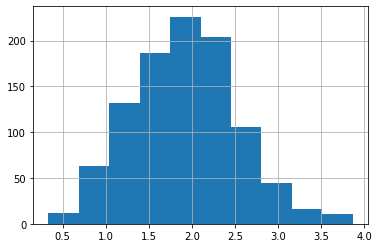

In [30]:
pd.Series(means).hist()

In [31]:
pd.Series(means).mean()

1.9142

In [32]:
pd.Series(means).quantile([.1, .9])

0.1    1.116667
0.9    2.666667
dtype: float64

In [33]:
import matplotlib.pyplot as plt

15.0% of CIs do not capture the true mean


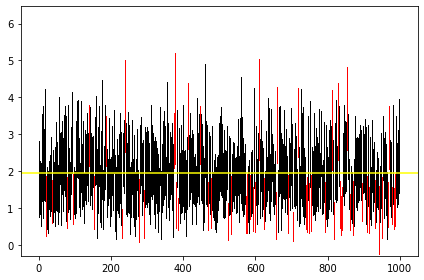

In [34]:
true_mean = df['mw'].mean()

top = np.array([ci[1] for ci in CIs])
bottom = np.array([ci[0] for ci in CIs])
y = top - bottom
x = np.arange(0,1000)
color = ['red' if true_mean > top or true_mean < bottom else 'black' for top, bottom in zip(top, bottom)]

print(str(color.count('red')/reps * 100) + '% of CIs do not capture the true mean')

fig, ax = plt.subplots()

ax.bar(x, y, bottom=bottom, width=1, color=color)
ax.axhline(true_mean, color='yellow')

plt.tight_layout()
plt.savefig('cis.png', format='png')
plt.show()
